# 6-2 CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# 디렉토리를 지정해주어 한번만 다운로드 되게끔
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir='drive/MyDrive/colab_data'
)

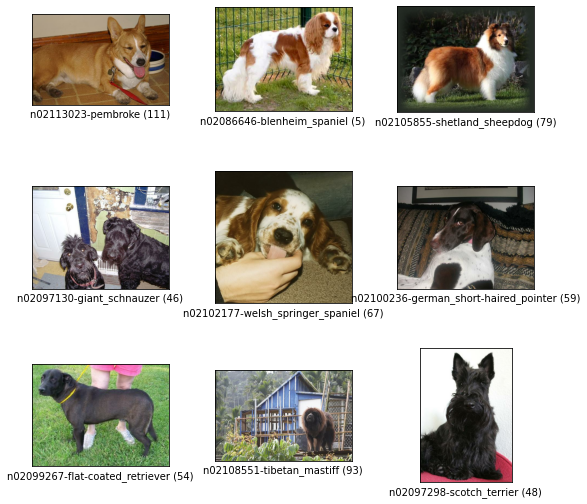

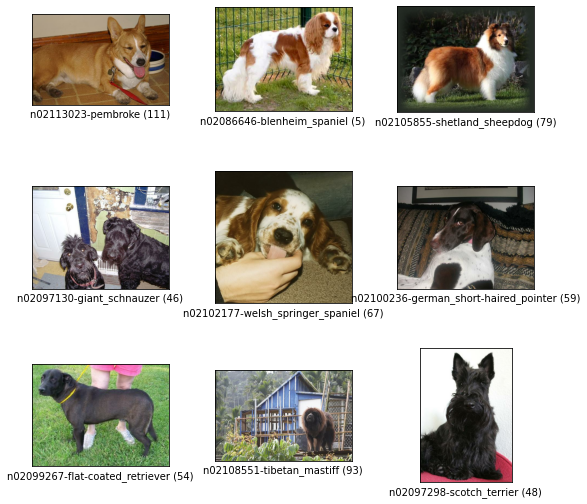

In [ ]:
tfds.show_examples(ds_train, ds_info)

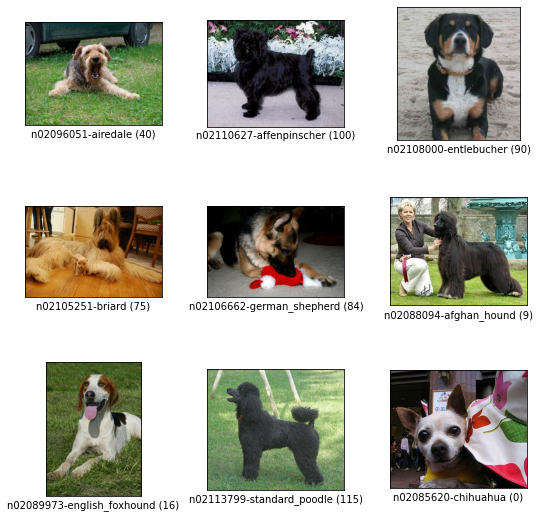

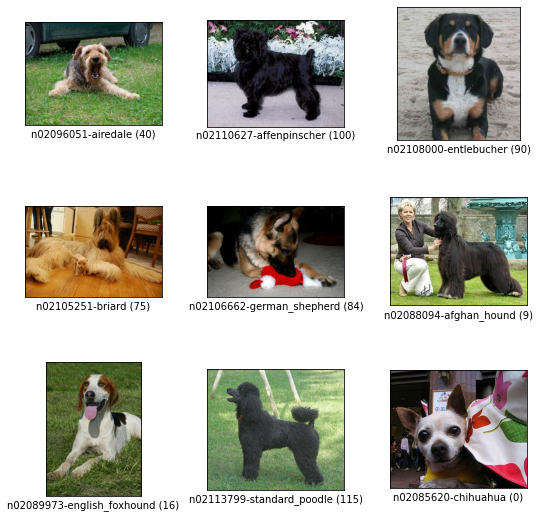

In [ ]:
tfds.show_examples(ds_test, ds_info)

# 6-3 CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

3채널로 이루어진 컬러 이미지이며, 클래스는 총 120개이다.  
또한 바운딩박스 정보가 주어진다.

# 6-4 CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output # 베이스 모델에서 나온 output을 입려으로 선언
preds = keras.layers.Dense(num_classes, activation='softmax')(x) # 2048개의 output을 클래스 갯수로 줄여준다.
cam_model = keras.Model(inputs=base_model.input, outputs=preds) # CAM모델 선언

In [ ]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# 6-5 CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기

input에 이전과 다르게 bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img과정에서 제외해 주었습니다. CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문입니다.

In [ ]:
def normalize_and_resize_img(input): # 이미지 사이즈를 바꾸고 정규화하는 함수
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16): # 통합 전처리를 수행하는 함수 선언
    # 리사이즈 및 정규화
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    # 데이터셋을 배치화
    ds = ds.batch(batch_size)
    # 데이터가 반복되도록하고 섞이도록 한다.
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    # 효율을 위해 prefetch화 한다.
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)
    print(label)

(16, 224, 224, 3)
(16,)
tf.Tensor([ 45  48  11  16 118 111   4 112  64  37  46  10 102   6  37  73], shape=(16,), dtype=int64)


모델 컴파일 및 학습  
20 EPOCHS를 진행하면서 조건에 맞으면 중단하도록 한다.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

EPOCH = 20 
BATCH_SIZE = 16

filename = '/content/drive/MyDrive/Colab Notebooks/GD_6/checkpoint-epoch-{}-batch-{}-trial-000.h5'.format(EPOCH, BATCH_SIZE)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_accuracy',   # val_accuracy 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

earlystopping = EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val-accuracy) 
                              patience=3,         # 3회 Epoch동안 개선되지 않는다면 종료
                             )

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint, earlystopping],
)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 2.2114 - accuracy: 0.4431
Epoch 1: val_accuracy improved from -inf to 0.16009, saving model to /content/drive/MyDrive/Colab Notebooks/GD_6/checkpoint-epoch-20-batch-16-trial-000.h5
750/750 [==============================] - 116s 133ms/step - loss: 2.2114 - accuracy: 0.4431 - val_loss: 3.7245 - val_accuracy: 0.1601
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 0.7468 - accuracy: 0.7929
Epoch 2: val_accuracy improved from 0.16009 to 0.67106, saving model to /content/drive/MyDrive/Colab Notebooks/GD_6/checkpoint-epoch-20-batch-16-trial-000.h5
750/750 [==============================] - 96s 128ms/step - loss: 0.7468 - accuracy: 0.7929 - val_loss: 1.0987 - val_accuracy: 0.6711
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.9300
Epoch 3: val_accuracy improved from 0.67106 to 0.70995, saving model to /content/drive/MyDrive/Colab Notebooks/GD_6/checkpoint-epo

아홉번째 EPOCH을 마치고 중단됨.  
학습시킨 최종 가중치를 저장. (best 값은 체크포인트로 저장되어 있음)

In [ ]:
cam_model_path = 'drive/MyDrive/Colab Notebooks/GD_6/cam_model_0.h5'
cam_model.save(cam_model_path)

# 6-6 CAM

메모리 부족을 방지하기 위해서 런타임을 새로 시작하고 학습 된 모델을 불러와서 사용

In [1]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir='drive/MyDrive/colab_data'
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 함수 정의

In [2]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

80


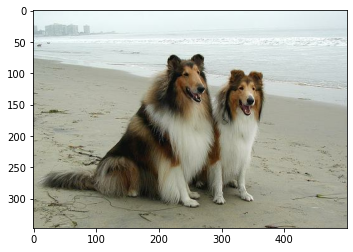

In [3]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

미리 준비된 학습한 모델을 불러온다.

In [4]:
#cam_model_path = 'drive/MyDrive/Colab Notebooks/GD_6/cam_model_1.h5'
cam_model_path = '/content/drive/MyDrive/Colab Notebooks/GD_6/checkpoint-epoch-20-batch-16-trial-000.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

CAM을 생성하기 위해서 필요한 것

(1) 특성 맵  
(2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치  
(3) 원하는 클래스의 출력값  

</br>
model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수 정의


In [5]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)

    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]
    
    # 픽셀 값에 0보다 작은 값이 있어서 결과영상이 매끄럽지 못한 부분이 있으므로, 음수가 없는 범위로 만들어주기위해 minmax 정규화를 진행
    cam_image  = (cam_image - np.min(cam_image)) / (np.max(cam_image) - np.min(cam_image))
    #cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

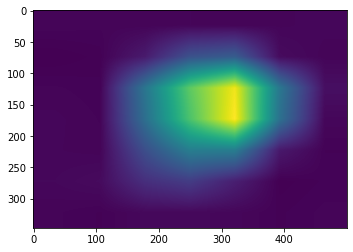

In [6]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

CAM 이미지를 원본 이미지와 합성

In [7]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

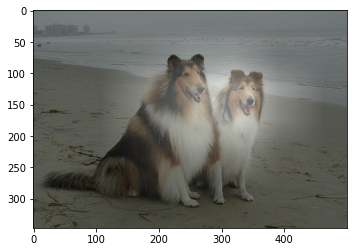

In [8]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

주로 강아지의 얼굴과 몸통이 있는 부분이 강조되는 경향이 있는데, 이것은 사람이 개를 식별할 때 유의해서 보는 부분과 일맥상통합니다.

# 6-7 Grad-CAM

67


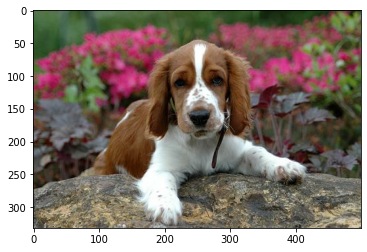

In [9]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [10]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0)) # 입력이 보통 배치형태이기 때문에 차원을 확장해줘 차원을 맞춰준다.
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다. 7x7x2048 의 shape 을 2048, 의 shape으로 바꿔줌
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]

    # 픽셀 값에 음수가 없도록 minmax 정규화 진행
    grad_cam_image  = (grad_cam_image - np.min(grad_cam_image)) / (np.max(grad_cam_image) - np.min(grad_cam_image))    
    #grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보세요! 레이어의 이름은 이전 스탭의 cam_model.summary() 결과에서 찾을 수 있습니다.

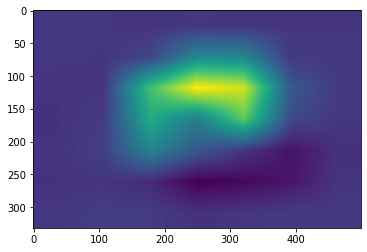

In [11]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

원 이미지와 합성

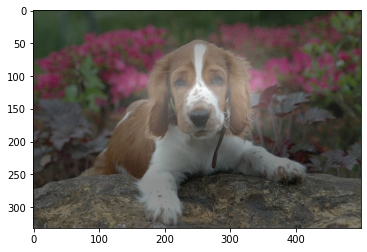

In [12]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

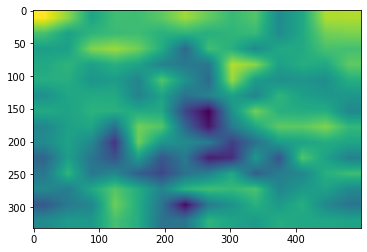

In [13]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

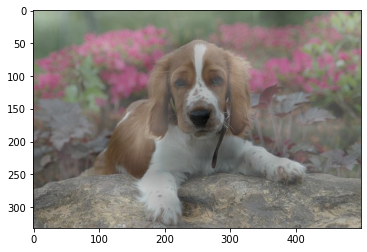

In [14]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

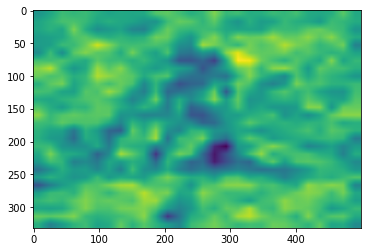

In [15]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

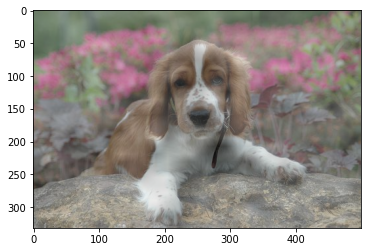

In [16]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# 6-8 Detection with CAM

**바운딩 박스**

CAM에서 물체의 위치를 찾는 detection 수행

새로운 이미지를 다시 뽑아 CAM 이미지를 뽑는다.

80


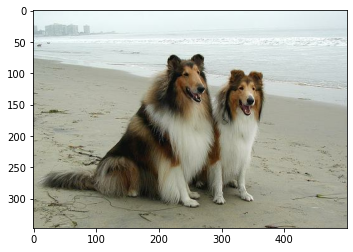

In [17]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

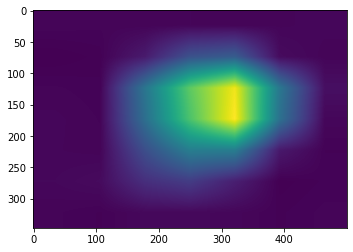

In [18]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [19]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # 사각형의 윤곽을 찾는다
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt) # 회전된 바운딩 박스 획득
    rect = cv2.boxPoints(rotated_rect) # 꼭지점으로 변환
    rect = np.int0(rect) # int 자료형으로 변환
    return rect

cam_image를 통해 bbox를 얻고 이를 이미지 위에 시각화

In [20]:
rect = get_bbox(cam_image)
rect

array([[115, 312],
       [115,  31],
       [461,  31],
       [461, 312]])

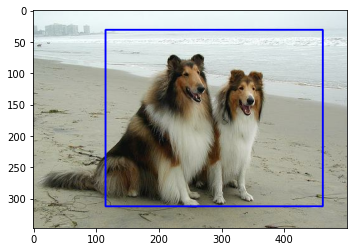

In [21]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

**Intersection Over Union**

정답 데이터인 바운딩 박스와 이를 비교, 평가

In [22]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

위에서 구했던 rect를 minmax bbox 형태로 치환

In [23]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0893371757925072, 0.23, 0.899135446685879, 0.922]

이 데이터의 ground truth bbox를 확인

In [24]:
item['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

CAM 추론 결과로 얻어진 bbox와 ground truth bbox 둘이 얼마나 유사한지를 IoU를 계산해서 확인

In [25]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [26]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.3440407120007369

# **Going Deeper 6. 프로젝트: CAM을 만들고 평가해 보자**

## 평가 루브릭

1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?  
\- ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.
<br/><br/>
2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?  
\- CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.
<br/><br/>
3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?  
\- CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.

**라이브러리 버전 확인하기**

사용할 라이브러리 버전을 확인해봐요.

In [27]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.8.0
1.21.5
4.1.2
7.1.2


새로운 이미지 뽑기

In [87]:
def get_one(ds):
    ds = ds.take(10)
    sample_data = list(ds.as_numpy_iterator())
    i = np.random.randint(0, 10)
    bbox = sample_data[i]['objects']['bbox']
    image = sample_data[i]['image']
    label = sample_data[i]['label']
    return sample_data[i]

9


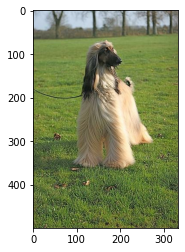

In [88]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

## **CAM 구현하기**

1) 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [89]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)

    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]
    
    # 픽셀 값에 0보다 작은 값이 있어서 결과영상이 매끄럽지 못한 부분이 있으므로, 음수가 없는 범위로 만들어주기위해 minmax 정규화를 진행
    cam_image  = (cam_image - np.min(cam_image)) / (np.max(cam_image) - np.min(cam_image))
    #cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

2) 만든 함수로 CAM 이미지를 생성합시다.

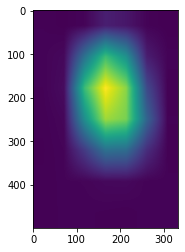

In [90]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

3) 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

In [91]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

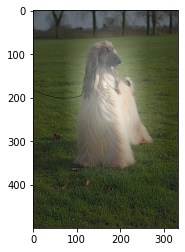

In [92]:
# visualize_cam_on_image() 함수 사용

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## **Grad-CAM 구현하기**

1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [93]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0)) # 입력이 보통 배치형태이기 때문에 차원을 확장해줘 차원을 맞춰준다.
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다. 7x7x2048 의 shape 을 2048, 의 shape으로 바꿔줌
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]

    # 픽셀 값에 음수가 없도록 minmax 정규화 진행
    grad_cam_image  = (grad_cam_image - np.min(grad_cam_image)) / (np.max(grad_cam_image) - np.min(grad_cam_image))    
    #grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

2) 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

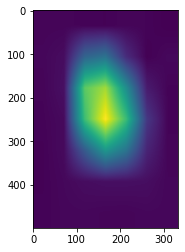

In [94]:
grad_cam_image_0 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image_0)
plt.show()

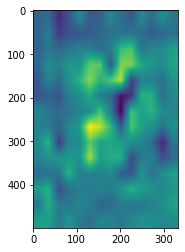

In [95]:
grad_cam_image_1 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image_1)
plt.show()

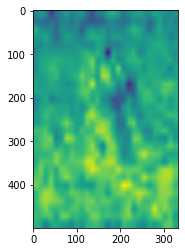

In [96]:
grad_cam_image_2 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image_2)
plt.show()

3) 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

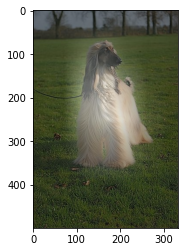

In [97]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image_0*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

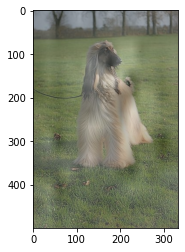

In [98]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image_1*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

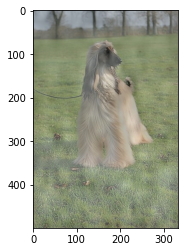

In [99]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image_2*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## **바운딩 박스 구하기**

1) 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

In [100]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # 사각형의 윤곽을 찾는다
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt) # 회전된 바운딩 박스 획득
    rect = cv2.boxPoints(rotated_rect) # 꼭지점으로 변환
    rect = np.int0(rect) # int 자료형으로 변환
    return rect

In [110]:
rect_cam = get_bbox(cam_image)
rect_0 = get_bbox(grad_cam_image_0)
rect_1 = get_bbox(grad_cam_image_1)
rect_2 = get_bbox(grad_cam_image_2)

print(rect_cam)
print(rect_0)
print(rect_1)
print(rect_2)

[[ 72 385]
 [ 72   0]
 [301   0]
 [301 385]]
[[ 72 390]
 [ 72  44]
 [296  44]
 [296 390]]
[[  0 498]
 [  0   0]
 [331   0]
 [331 498]]
[[  0 498]
 [  0   0]
 [331   0]
 [331 498]]


2) 1)에서 얻은 바운딩 박스를 시각화해 보세요.

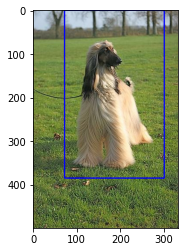

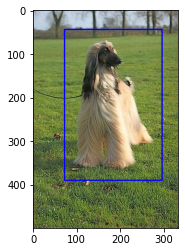

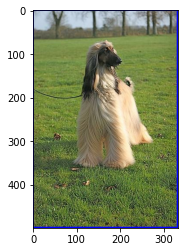

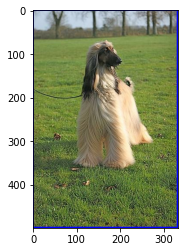

In [111]:
image_cam = copy.deepcopy(item['image'])
image_cam = cv2.drawContours(image_cam, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image_cam)
plt.show()

image_0 = copy.deepcopy(item['image'])
image_0 = cv2.drawContours(image_0, [rect_0], 0, (0,0,255), 2)
plt.imshow(image_0)
plt.show()

image_1 = copy.deepcopy(item['image'])
image_1 = cv2.drawContours(image_1, [rect_1], 0, (0,0,255), 2)
plt.imshow(image_1)
plt.show()

image_2 = copy.deepcopy(item['image'])

image_2 = cv2.drawContours(image_2, [rect_2], 0, (0,0,255), 2)
plt.imshow(image_2)
plt.show()

## **IoU 구하기**

1) 정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.

In [108]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

In [112]:
cam_bbox = rect_to_minmax(rect_cam, item['image'])
print(cam_bbox)

grad_bbox_0 = rect_to_minmax(rect_0, item['image'])
print(grad_bbox_0)

grad_bbox_1 = rect_to_minmax(rect_1, item['image'])
print(grad_bbox_1)

grad_bbox_2 = rect_to_minmax(rect_2, item['image'])
print(grad_bbox_2)

print(item['objects']['bbox'])

print(get_iou(cam_bbox, item['objects']['bbox'][0]))
print(get_iou(grad_bbox_0, item['objects']['bbox'][0]))
print(get_iou(grad_bbox_1, item['objects']['bbox'][0]))
print(get_iou(grad_bbox_2, item['objects']['bbox'][0]))



[0.0, 0.21621621621621623, 0.77, 0.9039039039039038]
[0.088, 0.21621621621621623, 0.78, 0.8888888888888888]
[0.0, 0.0, 0.996, 0.993993993993994]
[0.0, 0.0, 0.996, 0.993993993993994]
[[0.134      0.27327326 0.726      0.8378378 ]]
0.6311801831937112
0.718001662511271
0.3375920652475372
0.3375920652475372


---

# 결론 및 회고

* 노드를 따라 CAM 모델을 만들고 학습해보았다.  
20번의 Epoch으로 설정했는데 빠르게 수렵하여 9번만에 종료가 되었다.  
loss가 잘 떨어지고 accuracy도 잘 수렴하는 모습을 보였다.

* CAM 이미지를 원본 이미지와 합성하여 나타내니 어떤 부분을 보고 해당 object를 검출했는지 확인이 가능했다.  
주로 강아지의 얼굴부분을 보고 인식하는 것을 알 수 있는데, 이는 사람이 구분하는 방식과도 유사하다.  
Grad-CAM에서도 거의 유사한 결과를 나타낸다.  
가장 마지막 결과 레이어에서 얻어낸 Grad-CAM이 가장 잘 표현하는 모습을 보여준다.

* 바운딩 박스의 IoU를 확인한 결과, Grad-CAM을 이용한 결과가 가장 좋았다.  
IoU 값이 약 0.72에 달하는데 이는 바운딩박스 데이터와 72%의 겹침이 있다는 것을 뜻한다.  
상위 레이어에서 얻어진 Grad-CAM에서는 의미있는 바운딩 박스를 찾지 못했다.  
기본 CAM 모델도 나쁘지 않은 결과를 나타냈지만 Grad-CAM에 비하면 낮은 성능을 나타냈다.

* 어떤식으로 인식이 이루어지는지 눈으로 확인할 수 있어서 의미있었던 노드였다.  
추후 프로젝트를 진행하며 성능이 잘 나오지 않을때 이렇게 확인해보면 아주 유용할 것 같다.
